<h1>Train model on the training set, then test it on the training set with added noise - 209 datapoints. Train and Test on the same data points, hence, equal data size </h1>

In [21]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import time
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Optimizer
optimizer = tf.keras.optimizers.Adam(0.001)

#K-fold
k_fold = 4
k = k_fold
max_epoch = 100
# optimizer = tf.keras.optimizers.Adagrad(0.003)

In [22]:
k

4

In [3]:
rdkit.__version__

'2021.09.3'

In [4]:
dc.__version__

'2.6.1'

In [5]:
np.__version__

'1.21.4'

In [6]:
tf.__version__

'2.8.0'

In [7]:
# Loading molecular data - normal dataset
df = pd.read_csv('molecule_parameters.csv')
df.dropna(how='any', inplace=True)

In [8]:
# DDG Standard deviation
np.std(df.ddg)

2.697637870606162

In [12]:
df['entropy'][0]

'-34.07407324'

In [9]:
# Normalizing entropy and add some noise - Noisy dataset
df_noisy = pd.read_csv('molecule_parameters.csv')
df_noisy.dropna(how='any', inplace=True)
df_noisy['entropy'] = df_noisy['entropy'].astype(float) + np.random.normal(np.sqrt(df_noisy['entropy'].astype(float).mean()), 1, len(df_noisy))

In [10]:
# DDG Standard deviation Noisy dataset
np.std(df_noisy.ddg)

2.697637870606162

In [11]:
df_noisy['entropy'][0]

-31.83286312254761

# Reading PDB files

In [1]:
# # start time
# start = time.time()
# # Dictionary with complex names as keys and molecule as values
# PDBs = {}
# from os import listdir
# from os.path import isfile, join
# # mypath = '../../../../../../Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/pdbbind/raw-data/'
# mypath = '500/'
# onlyfiles = [f for f in listdir(mypath) if f not in ('.DS_Store') and f in (df['complex-name'].tolist())]
# for f in onlyfiles:
#     print(f)
#     PDBs.update({f: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + f + '/com_new.pqr')})

# for key, value in dict(PDBs).items():
#     if value is None:
#         del PDBs[key]
# time.sleep(1)
# # end time
# end = time.time()
# # total time taken
# print(f"PDB file reading runtime is {(end - start)/60} minutes")

In [18]:
# ## Save PDB
# import pickle
# with open('PDBs-500.pkl', 'wb') as file:
#     pickle.dump(PDBs, file)

In [13]:
## Load PDB
import pickle
PDBs = {}
with open('PDBs-234.pkl', 'rb') as file:
    PDBs = pickle.load(file)

In [14]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

In [19]:
len(PDBs)

207

# Models

<h3>PGNNS model </h3>

In [13]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
# batch_size = int(len(pdb_names_train)/4)
# batch_size
# batch_size=10

In [15]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class PGNNS(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(PGNNS, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([0.5, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
# PGNNS = PGNNS(train_split_index)
# PGNNS.compile(loss='mse', optimizer='adam')

<h3> DDS</h3>

In [16]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class DDS(tf.keras.Model):
   
    def modify_graphgather(self, batch_size):
        self.readout.batch_size = batch_size
        self.batch_size = batch_size

    def __init__(self, batch_size):
        super(DDS, self).__init__()
        self.input_shapes = None
        self.batch_size = batch_size
        self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(1)
    #     self.dense3 = layers.Dense(1, 
    #          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
    #          bias_initializer=initializers.Zeros())

    def call(self, inputs):
        inputs = inputs[0]
        x = []
    #     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
    #                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
        for i in range(len(self.input_shapes)):
            x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
        for i in range(1, len(self.input_shapes)):
            x[i] = tf.cast(x[i], tf.int32)
        x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
        gc1_output = self.gc1(x)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + x[1:])

        gc2_output = self.gc2([gp1_output] + x[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + x[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + x[1:])

        model_var = self.dense2(readout_output)
    #     binding_affinity = tf.concat([model_var, x_add], axis=1)
        return model_var #self.dense3(binding_affinity)
# DDS_model = DDS(train_split_index)
# DDS_model.compile(loss='mse', optimizer="adam")

In [23]:
k

4

# K-fold

In [25]:
import warnings
warnings.filterwarnings('ignore')

TRAIN_SET_PERCENTAGE = (1/k)
VAL_SET_PERCENTAGE = 1/k
PDBs.pop('',None)

# PGNNS model variables
PGNNS_train_losses = [[] for _ in range(k_fold)]
PGNNS_val_losses = [[] for _ in range(k_fold)]
PGNNS_rmse_train, PGNNS_rmse_test = [], []

# DDS model variables
DDS_train_losses = [[] for _ in range(k_fold)]
DDS_val_losses = [[] for _ in range(k_fold)]
DDS_rmse_train, DDS_rmse_test = [], []

# Defining Featurizer
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

# start time
start = time.time()

X, X_ids = [], []

# Featurize PDB's
for i in PDBs.keys():
    X_ids.append(i)
    X.append(featurizer.featurize(PDBs[i]))
    
pdb_names = [i.split('-')[0] for i in X_ids] 
X = [x[0] for x in X]

# k-fold loop
for fold in range(k_fold):
    # fold=0 -> 0 * (0.25 * 72) = 0
    # fold=1 -> 1 * (0.25 * 72) = 18
    # fold=2 -> 2 * (0.25 * 72) = 36
    # fold=3 -> 3 * (0.25 *72) = 54
    pdb_names_val, pdb_names_test = [], []
    pdb_names_train, X_val_featurized, X_test_featurized, X_train_featurized  = [], [], [], []
    

     
    TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)
    val_split_index_begin = int(fold * TEST_SIZE)
#     print(f"begin {val_split_index_begin}")
    val_split_index_end = int(val_split_index_begin) + int(TEST_SIZE)
#     print(f"end {val_split_index_end}")

    # validation
    pdb_names_val = pdb_names[val_split_index_begin:val_split_index_end]

    # Test set
    pdb_names_test = pdb_names[val_split_index_begin:val_split_index_end]
    
    # Train set
    # pdb_names_train = [pdb_names[i] for i in range(len(pdb_names)) if i not in range(val_split_index_begin,val_split_index_end)]
    pdb_names_train =  pdb_names[val_split_index_begin:val_split_index_end]
   
    
    X_val_featurized = X[val_split_index_begin : val_split_index_end]
    X_test_featurized = X[val_split_index_begin : val_split_index_end]
    # X_train_featurized = [X[i] for i in range(len(X)) if i not in range(val_split_index_begin, val_split_index_end)]
    X_train_featurized = X[val_split_index_begin : val_split_index_end]
    
    ### Step
    
    x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
    # Train
    for i in range(len(pdb_names_train)):
        new_df = df[(df['complex-name'] == pdb_names_train[i])]
        y_train.append(new_df['ddg'].to_numpy()[0])
        x_add_train.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_train = np.array(y_train)
    # Val
    for i in range(len(pdb_names_val)):
        new_df = df[(df['complex-name'] == pdb_names_val[i])]
        y_val.append(new_df['ddg'].to_numpy()[0])
        x_add_val.append(new_df[[c for c in df.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_val = np.array(y_val)

    # Test
    for i in range(len(pdb_names_test)):
        new_df = df_noisy[(df_noisy['complex-name'] == pdb_names_test[i])]
        y_test.append(new_df['ddg'].to_numpy()[0])
        x_add_test.append(new_df[[c for c in df_noisy.columns if ('etot' not in c) and ('delta' not in c)
                             and ('gb-' in c or 'vdwaals' in c or 'entropy' in c)]].to_numpy()[0])
    y_test = np.array(y_test)
    
    x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []
    
    ## Step
    
    # X train
    multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
    x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_train.append(np.array(x_add_train))

    ## X val
    multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
    x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_val.append(np.array(x_add_val))


    ## X test
    multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
    x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_test.append(np.array(x_add_test))
    
    ### Step
    
    # Train
    x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
                      np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_train):
        if len(j.shape) > 1:
            x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_train = x_train.reshape([1] + list(x_train.shape))

    # Validation
    x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
                      np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_val):
        if len(j.shape) > 1:
            x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_val = x_val.reshape([1] + list(x_val.shape))

    # Test
    x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
                      np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_test):
        if len(j.shape) > 1:
            x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_test = x_test.reshape([1] + list(x_test.shape))
    
    # Variable initializations for models
    
    val_size = len(y_val)
    train_size = len(y_train)
    
    # PGNNS Model
    batch_size = len(pdb_names_train)
    PGNNS_model = PGNNS(len(y_train))
    PGNNS_model.compile(loss='mse', optimizer=optimizer)
    print(f'PGNNS Model Fold # {fold}')
    for epoch in range(max_epoch):
        PGNNS_model.modify_graphgather(train_size)
        PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_train]
        PGNNloss = PGNNS_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        PGNNS_train_losses[fold].append(PGNNloss.history['loss'][0])
        PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_val]
        PGNNS_model.modify_graphgather(val_size)
        PGNNS_val_losses[fold].append(PGNNS_model.evaluate(x_val, y_val.reshape([1, -1])))
        
    PGNNS_model.input_shapes = [i.shape for i in x_preprocessed_test]
    PGNNS_model.modify_graphgather(len(y_test))
    evalu = PGNNS_model.evaluate(x_test, y_test.reshape([1, -1]))
    # PGNNS Testing RMSE calculation
    PGNNS_rmse_test.append(np.sqrt(evalu))
    print(PGNNS_rmse_test)
    # PGNNS Training RMSE calculation
    PGNNS_train_loss = PGNNS_train_losses[fold][-1]
    PGNNS_rmse_train.append(math.sqrt(PGNNS_train_loss))
    
    # Data Driven model
    DDS_model = DDS(len(y_train))
    DDS_model.compile(loss='mse', optimizer=optimizer)
    print(f'DDS Model Fold # {fold}')
    for epoch in range(max_epoch):
        DDS_model.modify_graphgather(train_size)
        DDS_model.input_shapes = [i.shape for i in x_preprocessed_train]
        DDSloss = DDS_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        DDS_train_losses[fold].append(DDSloss.history['loss'][0])
        DDS_model.input_shapes = [i.shape for i in x_preprocessed_val]
        DDS_model.modify_graphgather(val_size)
        DDS_val_losses[fold].append(DDS_model.evaluate(x_val, y_val.reshape([1, -1])))
    
    DDS_model.input_shapes = [i.shape for i in x_preprocessed_test]
    DDS_model.modify_graphgather(len(y_test))
    DDS_evaluate = DDS_model.evaluate(x_test, y_test.reshape([1, -1]))
    # DDS Testing RMSE calculation
    DDS_rmse_test.append(np.sqrt(DDS_evaluate))
    print(DDS_rmse_test)
    # DDS training RMSE calculation
    DDS_train_loss = DDS_train_losses[fold][-1]
    DDS_rmse_train.append(math.sqrt(DDS_train_loss))
    
time.sleep(1)
# end time
end = time.time()
# total time taken
print(f"Model training and testing runtime is {(end - start)/60} minutes")

PGNNS Model Fold # 0
1/1 [==============================] - 0s 441ms/step - loss: 36.7630
[6.063252825056583]
DDS Model Fold # 0
1/1 [==============================] - 0s 275ms/step - loss: 36.3465
[6.028803037457197]
PGNNS Model Fold # 1
1/1 [==============================] - 0s 336ms/step - loss: 28.6963
[6.063252825056583, 5.356888530688744]
DDS Model Fold # 1
1/1 [==============================] - 0s 206ms/step - loss: 31.7003
[6.028803037457197, 5.630301118051471]
PGNNS Model Fold # 2
1/1 [==============================] - 0s 392ms/step - loss: 38.5316
[6.063252825056583, 5.356888530688744, 6.207384314317486]
DDS Model Fold # 2
1/1 [==============================] - 0s 261ms/step - loss: 35.1247
[6.028803037457197, 5.630301118051471, 5.926610658521874]
PGNNS Model Fold # 3
1/1 [==============================] - 0s 372ms/step - loss: 26.3210
[6.063252825056583, 5.356888530688744, 6.207384314317486, 5.130403229033803]
DDS Model Fold # 3
1/1 [==============================] - 0s 226m

In [26]:
# PDBs

In [27]:
# chekcing the wights after training PGNNS MODEL
PGNNS_model.layers[-1].get_weights()

[array([[ 0.45811644],
        [ 1.0001318 ],
        [ 1.0000913 ],
        [ 1.0004071 ],
        [ 1.0049083 ],
        [-0.99985355],
        [-0.99990916],
        [-0.99963033],
        [-0.9950718 ],
        [-1.0028148 ],
        [-1.0051893 ],
        [-0.9983552 ],
        [-0.9932972 ],
        [ 0.9997539 ],
        [-1.0001426 ],
        [-1.0083337 ],
        [-0.99602777]], dtype=float32),
 array([0.00531951], dtype=float32)]

In [28]:
# calculating the average RMSE on Training set
average_DDS_rmse_train = sum(DDS_rmse_train) / len(DDS_rmse_train)
average_PGNNS_rmse_train = sum(PGNNS_rmse_train) / len(PGNNS_rmse_train)
# calculating the average RMSE on Testing set
average_DDS_rmse_test = sum(DDS_rmse_test) / len(DDS_rmse_test)
average_PGNNS_rmse_test = sum(PGNNS_rmse_test) / len(PGNNS_rmse_test)

# Model Performance Graphs

<h3>PGNNS Model </h3>

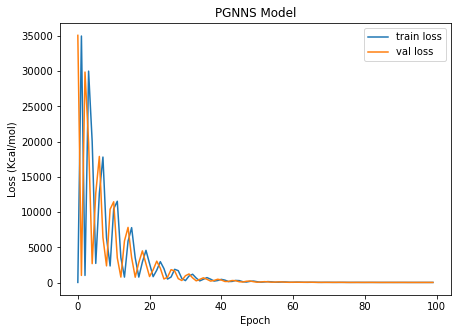

In [29]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_PGNNS_train_losses = [sum(x)/len(x) for x in zip(*PGNNS_train_losses)]
average_PGNNS_val_losses = [sum(x)/len(x) for x in zip(*PGNNS_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_PGNNS_train_losses)), average_PGNNS_train_losses, label='train loss')
plt.plot(range(len(average_PGNNS_val_losses)), average_PGNNS_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title("PGNNS Model")
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("PGNNS_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

<h3>DDS Model </h3>

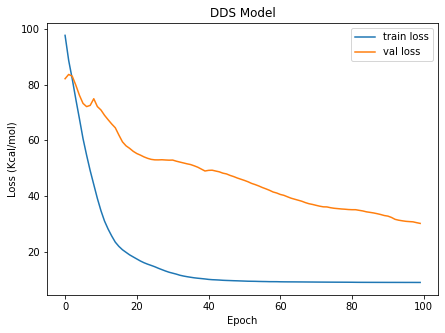

In [30]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_DDS_train_losses = [sum(x)/len(x) for x in zip(*DDS_train_losses)]
average_DDS_val_losses = [sum(x)/len(x) for x in zip(*DDS_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_DDS_train_losses)), average_DDS_train_losses, label='train loss')
plt.plot(range(len(average_DDS_val_losses)), average_DDS_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title('DDS Model')
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("DDS_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

# Comparison

In [33]:
from prettytable import PrettyTable
# Train
rmse_table = PrettyTable()
rmse_table.title="Models Comparison"
rmse_table.field_names = ["DDS (TRAIN)", "PGNNS (TRAIN)", "DDS (TEST)", "PGNNS (TEST)"]
rmse_table.add_row([ "{:.2f}".format(average_DDS_rmse_train),"{:.2f}".format(average_PGNNS_rmse_train),
                   "{:.2f}".format(average_DDS_rmse_test),"{:.2f}".format(average_PGNNS_rmse_test)])

print(rmse_table) 

+---------------------------------------------------------+
|                    Models Comparison                    |
+-------------+---------------+------------+--------------+
| DDS (TRAIN) | PGNNS (TRAIN) | DDS (TEST) | PGNNS (TEST) |
+-------------+---------------+------------+--------------+
|     2.98    |      3.87     |    5.44    |     5.69     |
+-------------+---------------+------------+--------------+
